# Semi-Supervised Learning

## 필수 라이브러리 import

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import pickle

## 데이터 불러오기
- TIM-Net을 통해 추출한 감정 결과 csv를 df로 불러옴

In [2]:
labeled_df = pd.read_csv("./data/labeled.csv", index_col=0)
unlabeled_df = pd.read_csv("./data/emotion_un-labeled_ETRI.csv", index_col=0)

print(labeled_df.shape, unlabeled_df.shape)

(1354, 9) (12461, 8)


## 데이터 전처리

In [3]:
X= labeled_df.iloc[:,2:]
y = labeled_df.iloc[:,0]

print(X.shape, y.shape)

(1354, 7) (1354,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1083, 7) (1083,)
(271, 7) (271,)


In [5]:
X_train_label = X_train
y_train_label = y_train
X_test_label = X_test
y_test_label = y_test
without_label = unlabeled_df.iloc[:,1:]

print(without_label.shape)

(12461, 7)


## 준지도 학습
- 이전 코드를 통해 선정된 최고 성능의 binary classifier & parameters 
- RandomForest(default parameters)

#### functions

In [6]:
# cycle마다 성능 개선 단계를 파악하기 위한 함수
def evaluation(y_true,y_pred):
    print("Accuracy: {:.2f}".format(accuracy_score(y_true,y_pred)))
    print("Precision: {:.2f}".format(precision_score(y_true,y_pred)))
    print("Recall: {:.2f}".format(recall_score(y_true,y_pred)))
    print("f1-score: {:.2f}".format(f1_score(y_true,y_pred)))
    print("ROC_AUC: {:.2f}".format(roc_auc_score(y_true,y_pred)))
    print(confusion_matrix(y_true,y_pred))

In [7]:
# confidence
# RandomForestClassifier 결과는 [0] : 0일 확률, [1] : 1일 확률 이므로
# 둘 중 더 큰 값으로 predict하며, 해당 값이 confidence 값이 된다.
def confidence_prediction(df):
    result = []
    for i in range(len(df)):
        if df[i][0] >= df[i][1]:
            result.append(df[i][0])
        else:
            result.append(df[i][1])
    return result    

#### Main Loop

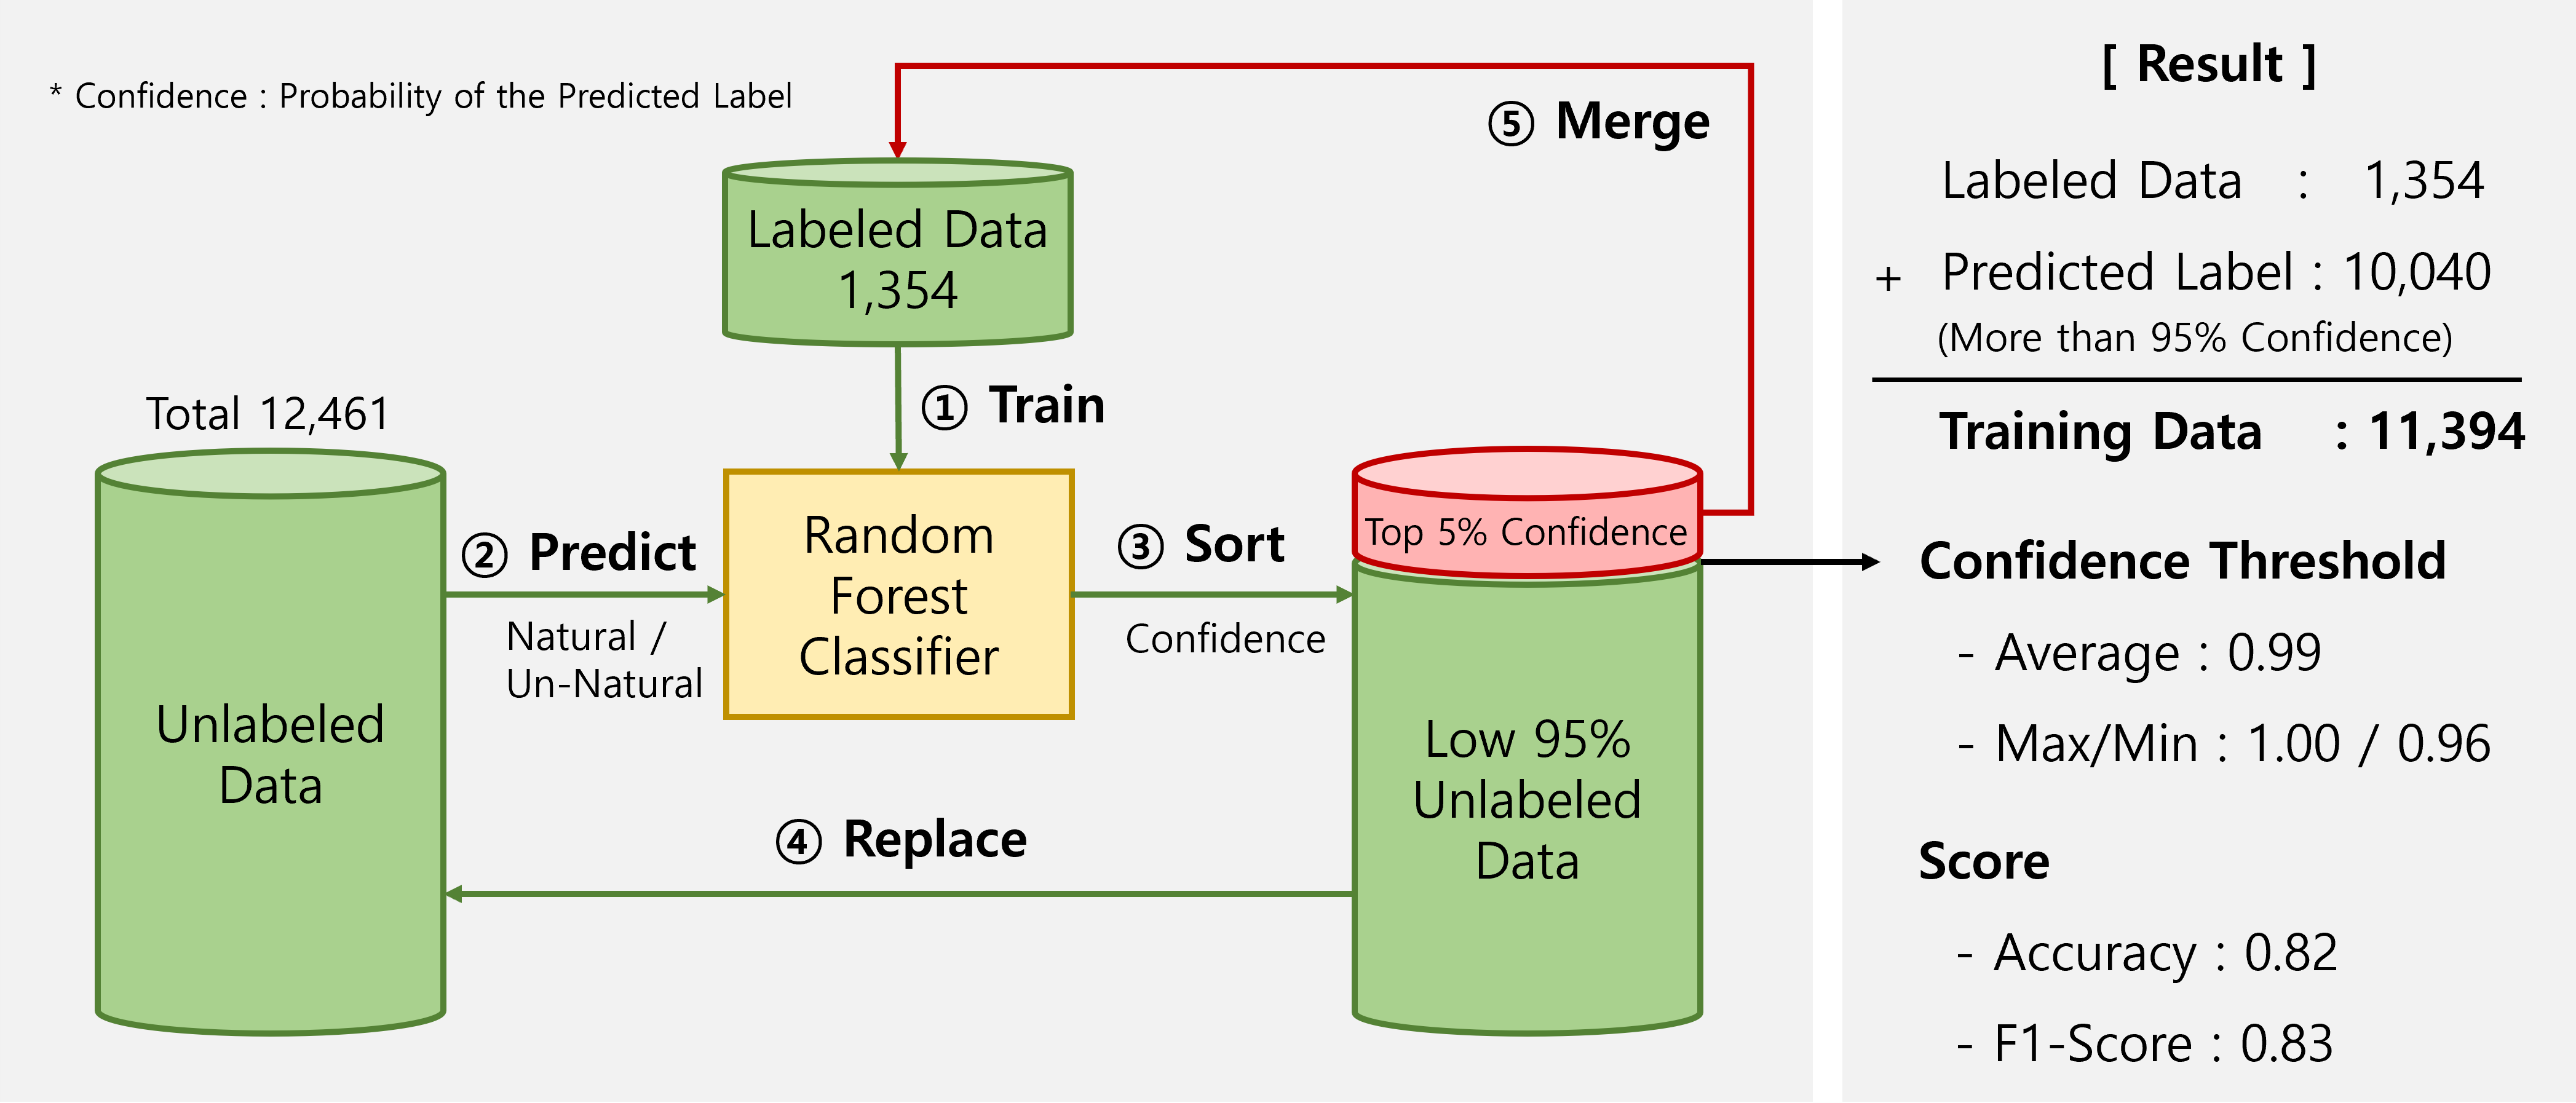

In [8]:
#model에 대한 라이브러리 추가
from sklearn.ensemble import RandomForestClassifier

In [9]:
# Hyperparameters
PERCENTAGE = 5          # unlabeled data 중 confidence 상위 5% 데이터를 학습에 사용
UNLABELED_USAGE = 80    # unlabeled data 중 80%만 학습에 사용 (낮은 confidence를 가진 데이터는 학습에서 제외)

# Define number of total unlabeled data, unused unlabeled data
TOTAL_UNLABELED_NUM = without_label.shape[0]      # 전체 unlabeled data 수
UNUSING_UNLABELED_NUM = int(TOTAL_UNLABELED_NUM * (100 - UNLABELED_USAGE) * 0.01) # 사용하지 않는 unlabeled data 수

# Initialize cycle count, a list to store confidences
cycle_cnt = 0
conf_list = []
finish = False # 반복문 종료 스위치

# Main loop for Semi-Supervised Learning
while True:
    
    # Stop Condition 1 : cycle count == 1000
    if cycle_cnt == 1000:  # Avoid infinite loop
        print(f"!!! Approach limit {cycle_cnt} !!!")
        finish = True
    cycle_cnt += 1
    
    # Stop Condition 2 : number of left_unlabeled >= number of UNUSING_DATA
    if without_label.shape[0] >= UNUSING_UNLABELED_NUM and not finish:
        print(f"\n===== {cycle_cnt} cycle =====")
        
        ### Modify model & parameters ###
        model = RandomForestClassifier()
        ##################################
        
        # 1) Training model
        model.fit(X_train_label, y_train_label)
        y_pred_label = model.predict(X_test_label)
        evaluation(y_test_label, y_pred_label)
        
        # 2) Predictions for unlabeled data
        prob = model.predict_proba(without_label)   # [natural일 확률 , un-natural일 확률]
        confidence_prob = confidence_prediction(prob)
        without_label['confidence'] = confidence_prob
        
        # 3) Sorting by confidence in descending order
        without_label = without_label.sort_values(by=['confidence'], ascending=False)
        without_label = without_label.reset_index(drop=True)
        
        # 4) Replace existing unlabeled_data with confidence bottom 95% of unlabled_data
        
        ## 4-1) Define cutting_index
        cutting_index = int(without_label.shape[0] * (PERCENTAGE * 0.01)) # 남은 unlabeled_data * 5%
        one_cycle_last_conf = without_label['confidence'][cutting_index]
        conf_list.append(one_cycle_last_conf)
        print(f"Threshold confidence: {without_label['confidence'][cutting_index]}")
        
        ## 4-2) Divide into chosen & notchosen
        
        ### 4-2-1) Define chosen_without_label & pseudo_label
        chosen_without_label = without_label.iloc[:cutting_index, :]
        chosen_without_label = chosen_without_label.drop(columns={'confidence'})
        pseudo_label = pd.DataFrame(model.predict(chosen_without_label))
        
        ### 4-2-2) Define notchosen_without_label
        notchosen_without_label = without_label.iloc[cutting_index:, :]
        notchosen_without_label = notchosen_without_label.drop(columns={'confidence'})
        
        ## 4-3) Replace without_lable with notchosen_without_label
        without_label = notchosen_without_label
        
        # 5) Merge labeled_data with unlabeled_data (top 5%)
        X_train_label = pd.concat([X_train_label, chosen_without_label]) # X : labeled_data에 top 5% unlabeled_data를 merge
        y_train_label = pd.concat([y_train_label, pseudo_label])         # y : labeled_data에 y_pred를 merge
        
        
    # Finish semi-supervised learning    
    else:
        # 전체 사용한 데이터 개수 출력
        using_unlabeled = TOTAL_UNLABELED_NUM - without_label.shape[0]
        print(f"ALL DONE, UNLABELED LEARNING USED: {using_unlabeled} ({(100 * using_unlabeled) // TOTAL_UNLABELED_NUM}%).")
        break


===== 1 cycle =====
Accuracy: 0.82
Precision: 0.79
Recall: 0.88
f1-score: 0.83
ROC_AUC: 0.82
[[103  32]
 [ 17 119]]
Threshold confidence: 1.0

===== 2 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.80
Precision: 0.78
Recall: 0.85
f1-score: 0.81
ROC_AUC: 0.80
[[102  33]
 [ 20 116]]
Threshold confidence: 1.0

===== 3 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.87
f1-score: 0.83
ROC_AUC: 0.82
[[103  32]
 [ 18 118]]
Threshold confidence: 1.0

===== 4 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[100  35]
 [ 16 120]]
Threshold confidence: 1.0

===== 5 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.86
f1-score: 0.82
ROC_AUC: 0.81
[[102  33]
 [ 19 117]]
Threshold confidence: 1.0

===== 6 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[100  35]
 [ 16 120]]
Threshold confidence: 1.0

===== 7 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.87
f1-score: 0.83
ROC_AUC: 0.82
[[103  32]
 [ 18 118]]
Threshold confidence: 1.0

===== 8 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.86
f1-score: 0.82
ROC_AUC: 0.81
[[102  33]
 [ 19 117]]
Threshold confidence: 1.0

===== 9 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.83
Precision: 0.80
Recall: 0.89
f1-score: 0.84
ROC_AUC: 0.83
[[104  31]
 [ 15 121]]
Threshold confidence: 1.0

===== 10 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
f1-score: 0.83
ROC_AUC: 0.82
[[101  34]
 [ 16 120]]
Threshold confidence: 1.0

===== 11 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.82
[[102  33]
 [ 15 121]]
Threshold confidence: 1.0

===== 12 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[101  34]
 [ 17 119]]
Threshold confidence: 1.0

===== 13 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.78
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[101  34]
 [ 17 119]]
Threshold confidence: 1.0

===== 14 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.82
[[102  33]
 [ 15 121]]
Threshold confidence: 1.0

===== 15 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
f1-score: 0.83
ROC_AUC: 0.82
[[101  34]
 [ 16 120]]
Threshold confidence: 1.0

===== 16 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[100  35]
 [ 16 120]]
Threshold confidence: 0.99

===== 17 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.90
f1-score: 0.83
ROC_AUC: 0.82
[[100  35]
 [ 14 122]]
Threshold confidence: 0.96

===== 18 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.81
[[ 99  36]
 [ 15 121]]
Threshold confidence: 0.97

===== 19 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[100  35]
 [ 17 119]]
Threshold confidence: 0.99

===== 20 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.82
[[101  34]
 [ 15 121]]
Threshold confidence: 1.0

===== 21 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.89
f1-score: 0.82
ROC_AUC: 0.81
[[ 98  37]
 [ 15 121]]
Threshold confidence: 1.0

===== 22 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.82
[[102  33]
 [ 15 121]]
Threshold confidence: 0.99

===== 23 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.82
[[102  33]
 [ 15 121]]
Threshold confidence: 0.98

===== 24 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[100  35]
 [ 17 119]]
Threshold confidence: 0.99

===== 25 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.88
f1-score: 0.83
ROC_AUC: 0.82
[[102  33]
 [ 16 120]]
Threshold confidence: 0.98

===== 26 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.80
Precision: 0.77
Recall: 0.86
f1-score: 0.82
ROC_AUC: 0.80
[[101  34]
 [ 19 117]]
Threshold confidence: 0.98

===== 27 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.83
Precision: 0.79
Recall: 0.90
f1-score: 0.84
ROC_AUC: 0.83
[[103  32]
 [ 14 122]]
Threshold confidence: 0.98

===== 28 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[100  35]
 [ 16 120]]
Threshold confidence: 0.98

===== 29 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.81
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.81
[[100  35]
 [ 16 120]]
Threshold confidence: 0.97

===== 30 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.80
Precision: 0.77
Recall: 0.88
f1-score: 0.82
ROC_AUC: 0.80
[[ 99  36]
 [ 17 119]]
Threshold confidence: 0.96

===== 31 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.78
Recall: 0.90
f1-score: 0.84
ROC_AUC: 0.82
[[100  35]
 [ 13 123]]
Threshold confidence: 0.98

===== 32 cycle =====


C:\Users\tjdtl\AppData\Local\Temp\ipykernel_1216\2626383625.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_label, y_train_label)


Accuracy: 0.82
Precision: 0.79
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.82
[[102  33]
 [ 15 121]]
Threshold confidence: 0.97
ALL DONE, UNLABELED LEARNING USED: 10040 (80%).


#### Confidence information

In [10]:
np.mean(conf_list)

0.9896875

In [11]:
print(np.min(conf_list))
print(np.max(conf_list))

0.96
1.0


#### 모델 저장(백업)

In [12]:
with open('SEMI_SUPERVISED_LEARNING_RF.pkl', 'wb') as f:
    pickle.dump(model, f)

## 예측 및 평가

In [13]:
y_pred = model.predict(X_test_label)

print("y_test : ", y_test_label)
print("y_pred : ", y_pred)

y_test :  572    1.0
276    0.0
303    1.0
109    1.0
177    0.0
      ... 
145    0.0
290    0.0
159    0.0
526    1.0
587    1.0
Name: label, Length: 271, dtype: float64
y_pred :  [1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 1.

In [14]:
def print_score(y_test, y_pred):
    # 각각의 평가 지표 계산
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 결과 출력
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)

In [15]:
print("RandomForest Classifier")
evaluation(y_test_label,y_pred)

RandomForest Classifier
Accuracy: 0.82
Precision: 0.79
Recall: 0.89
f1-score: 0.83
ROC_AUC: 0.82
[[102  33]
 [ 15 121]]


In [16]:
def make_confusion_matrix(model_name, y_test, y_pred):
    cfm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cfm, annot=True, cbar=False)
    plt.title(model_name)
    plt.ylabel('Actual Class')
    plt.xlabel('Predict Class')
    plt.show()

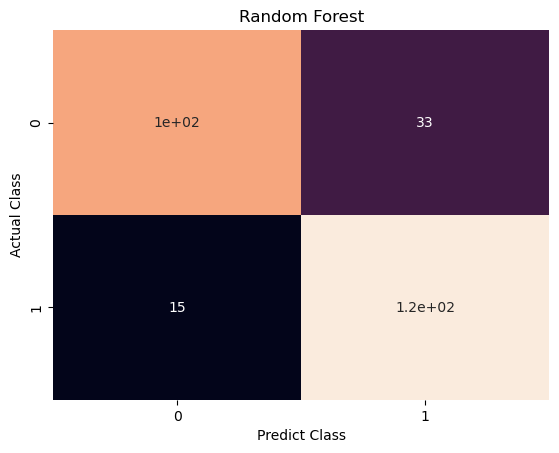

In [17]:
make_confusion_matrix("Random Forest", y_test_label, y_pred)